# Analyze Data

### 1. Import

In [1]:
import re
import numpy as np
import pandas as pd
import string
from nltk import pos_tag
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict 
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer

### 2. Preparet Data

In [2]:
news = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame(news.data, columns=['text'])
df["categories"] = [news.target_names[i] for i in news.target]
df["labels"] = [i for i in news.target]
df.head()

,text,categories,labels
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey,10
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware,3
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware,3
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware,4


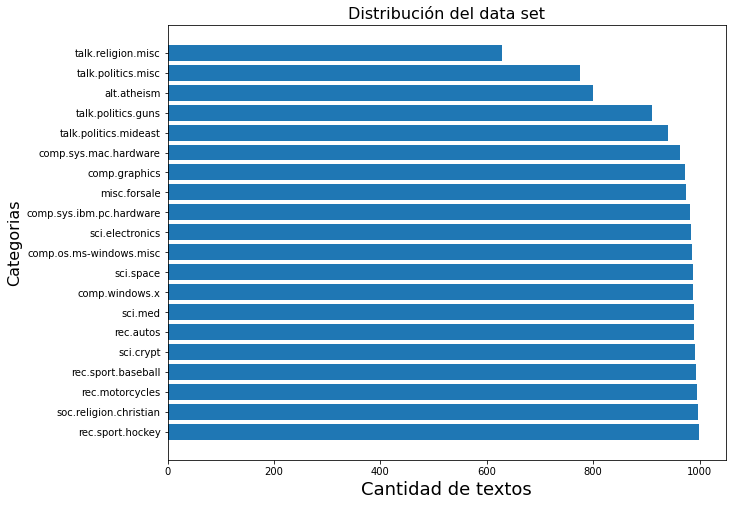

In [3]:
plt.figure("figure1", figsize=(10,8))
plt.barh(df['categories'].value_counts().index,df['categories'].value_counts().values)
plt.xlabel("Cantidad de textos", size=18)
plt.ylabel("Categorias", size=16)
plt.title("Distribución del data set", size=16)
plt.show()

### 3. preprocessing Data

In [4]:
def clear(df):
    signos = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    # Remove signo puntuacion 
    df["text"] = [re.sub(signos, ' ', sent) for sent in df["text"]]
    # Remove whitspace star and end text
    df['text'] = df['text'].str.strip()
    # Remove Emails
    df["text"] = [re.sub('\S*@\S*\s?', '', sent) for sent in df["text"]]
    # Remove distracting single quotes
    df["text"] = [re.sub("\'", "", sent) for sent in df["text"]]
    # Remove any rows with empty fields
    df = df.replace('', np.NaN).dropna()
    # Drop duplicates
    df = df.drop_duplicates(subset='text')
    # Remove number
    df['text'] = [re.sub('\d+', ' ', text) for text in df['text']]
    # lower
    df["text"] = [text.lower() for text in df["text"]]
    # Remove multiples whitspaces characters
    df["text"] = [re.sub('\s+', ' ', sent) for sent in df["text"]]

    return df

In [5]:
stopwords = stopwords.words('english') + list(string.punctuation)

In [6]:
def tokenization(text):
    tokens = re.split('\W',text)
    output= [i for i in tokens if i not in stopwords]
    return output

In [7]:
df = clear(df)
df['msg_tokenied']= df['text'].apply(lambda x: tokenization(x))
df.head()

,text,categories,labels,msg_tokenied
0,i am sure some bashers of pens fans are pretty...,rec.sport.hockey,10,"[sure, bashers, pens, fans, pretty, confused, ..."
1,my brother is in the market for a high perform...,comp.sys.ibm.pc.hardware,3,"[brother, market, high, performance, video, ca..."
2,finally you said what you dream about mediterr...,talk.politics.mideast,17,"[finally, said, dream, mediterranean, new, are..."
3,think it s the scsi card doing the dma transfe...,comp.sys.ibm.pc.hardware,3,"[think, scsi, card, dma, transfers, disks, scs..."
4,i have an old jasmine drive which i cannot us...,comp.sys.mac.hardware,4,"[, old, jasmine, drive, cannot, use, new, syst..."


#### 4. Analisis del data set

In [8]:
df_mod = df.explode(column='msg_tokenied')
df_mod = df_mod.drop(columns='text')
df_mod = df_mod.rename(columns={'msg_tokenied':'token'})
df_mod.head()

,categories,labels,token
0,rec.sport.hockey,10,sure
0,rec.sport.hockey,10,bashers
0,rec.sport.hockey,10,pens
0,rec.sport.hockey,10,fans
0,rec.sport.hockey,10,pretty


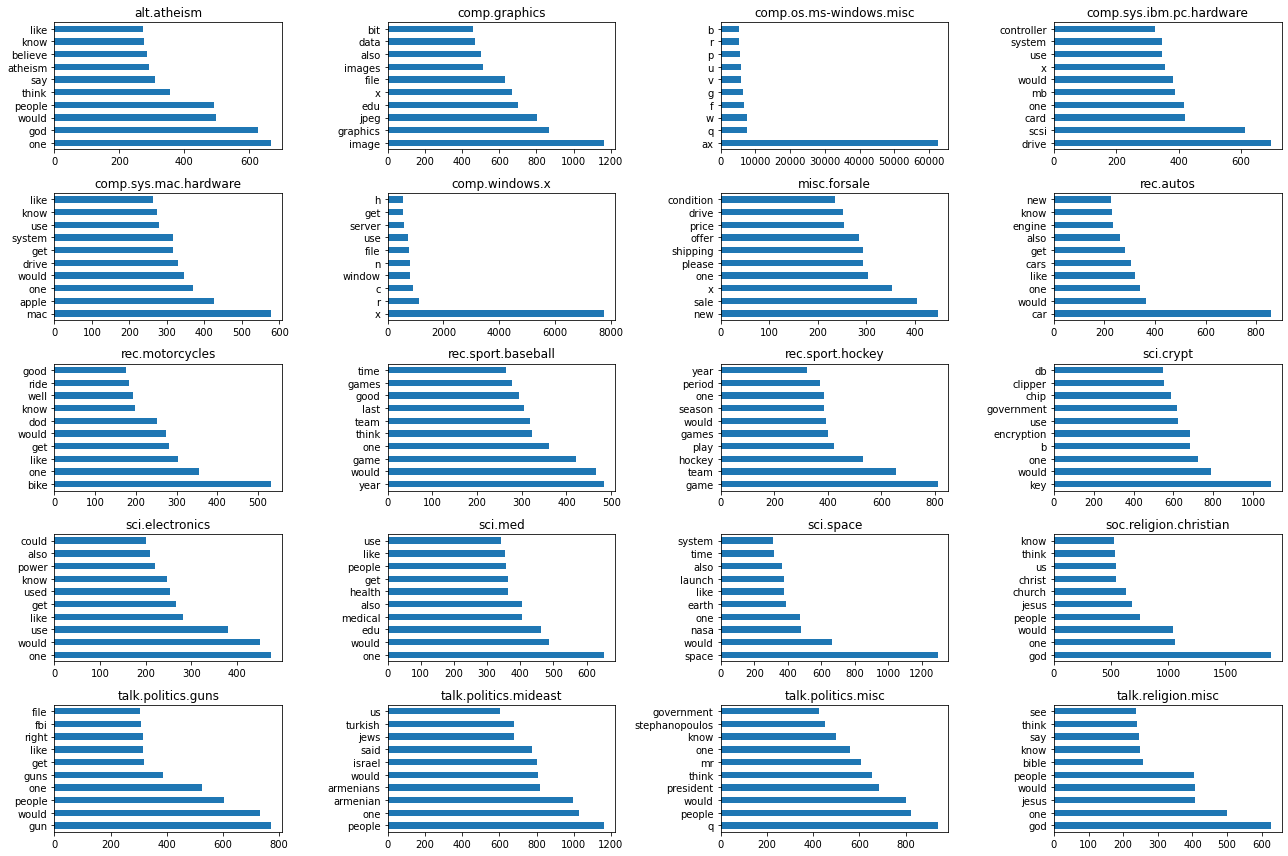

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(18,12))
ax = ax.ravel()
for i, target_name in enumerate(news.target_names):
    df_temp = df_mod[df_mod["categories"]==target_name]
    counts = df_temp["token"].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', ax=ax[i])
    ax[i].set_title(target_name)

fig.tight_layout()

Initialization complete
Iteration 0, inertia 1.8530203829625183
Iteration 1, inertia 1.5807020281776336
Iteration 2, inertia 1.5239467764687182
Iteration 3, inertia 1.4780893309648278
Iteration 4, inertia 1.4370223771955395
Iteration 5, inertia 1.4146993812824094
Iteration 6, inertia 1.4096231494146445
Iteration 7, inertia 1.4081167223092537
Iteration 8, inertia 1.4077096937407378
Iteration 9, inertia 1.4074714579226102
Iteration 10, inertia 1.4072377981117317
Iteration 11, inertia 1.4067979670733906
Iteration 12, inertia 1.4063687155852014
Iteration 13, inertia 1.4059225211817492
Iteration 14, inertia 1.4041893652797226
Iteration 15, inertia 1.403204295208907
Iteration 16, inertia 1.4008509607232558
Iteration 17, inertia 1.3988866744800608
Iteration 18, inertia 1.3984973273448398
Iteration 19, inertia 1.397941942705999
Iteration 20, inertia 1.3974546570200737
Iteration 21, inertia 1.3971657551815773
Converged at iteration 21: strict convergence.
Initialization complete
Iteration 0, in

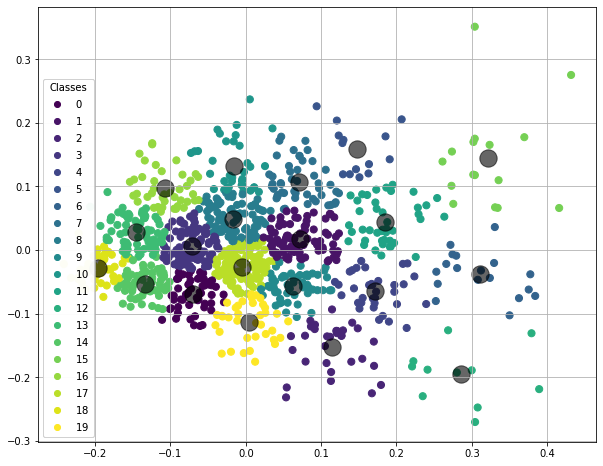

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['labels'], test_size=0.2)

TFIDFvectorizer = TfidfVectorizer()
X_train = TFIDFvectorizer.fit_transform(X_train)
Y_train = Y_train

X_test = TFIDFvectorizer.transform(X_test)
Y_test = Y_test

target_names = news.target_names


X_train_array = X_train[0:1000].toarray()
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_train_array)

Kmean = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0, verbose=True)

fitted = Kmean.fit(Y_sklearn)
predicted_values = Kmean.predict(Y_sklearn)

fig, ax = plt.subplots(figsize=(10,8))
scatter = ax.scatter(Y_sklearn[:,0], Y_sklearn[:, 1], c=predicted_values, s=50,cmap='viridis')
centers = fitted.cluster_centers_
scatter2 = ax.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(num=20),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.grid()
plt.show()


### 5. Conjunto de palabras

In [13]:
import pyLDAvis
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(df['text-tokenizer']))

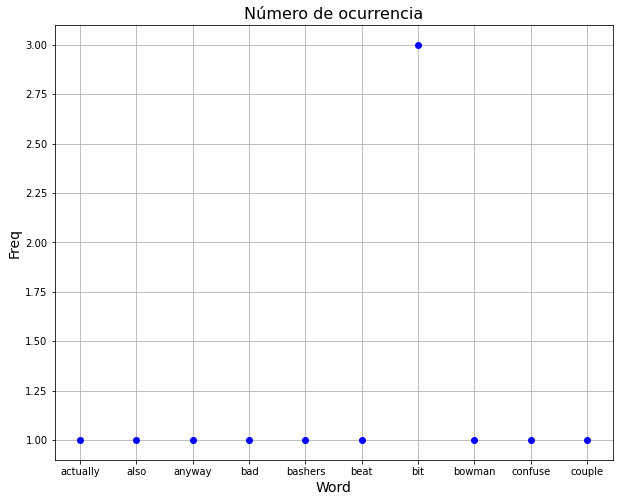

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
a = [[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

plt.figure(1,figsize=(10,8))
for i in range(0,10):
    plt.plot(a[0][i][0],a[0][i][1],'bo')

plt.title("Número de ocurrencia", size=16)
plt.xlabel("Word", size=14)
plt.ylabel("Freq", size=14)
plt.grid()    
plt.show()

In [19]:
# Build LDA model
lda_model = LdaModel( corpus         = corpus, 
						id2word      = id2word,
						num_topics   = 20,
						random_state=100,
						update_every = 1, 
						chunksize    = 100, 
						passes       = 10,
						alpha='auto',
						per_word_topics=True)

lda_model.save('modelLDA.model')


In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\Users\Maycol\env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.340986  0.069440       1        1  36.366187
5     -0.305155 -0.047696       2        1  14.347767
13    -0.162536 -0.043066       3        1   7.947550
18    -0.179460  0.177494       4        1   6.036857
0     -0.140019 -0.218745       5        1   5.571111
3     -0.090625  0.290685       6        1   4.905940
16     0.110604  0.000243       7        1   4.807934
4     -0.165710 -0.220511       8        1   4.789185
10     0.059719 -0.014104       9        1   1.937252
7      0.032017  0.010363      10        1   1.933849
19     0.063982  0.048110      11        1   1.829486
8      0.046973  0.030550      12        1   1.652700
6      0.106753 -0.022380      13        1   1.623940
15     0.090171 -0.010913      14        1   1.445385
12     0.104511 -0.005789      15        1   1.436590
9      0.117502 -0.002890      16        1   1.170793
11     0.133789 -0.011248      17        1   0.763440
2      0.160931 -0.012091      18        1   0.580686
14     0.174488 -0.009803      19        1   0.482704
1      0.183053 -0.007648      20        1   0.370644, topic_info=      Term          Freq         Total Category  logprob  loglift
2001    in  12265.000000  12265.000000  Default  30.0000  30.0000
1535   who  10809.000000  10809.000000  Default  29.0000  29.0000
193    use  16678.000000  16678.000000  Default  28.0000  28.0000
3119    ax   7812.000000   7812.000000  Default  27.0000  27.0000
2628   god   7631.000000   7631.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
6081    be      0.051196      1.654309  Topic20 -11.7984   2.1222
6100   not      0.051196      1.654280  Topic20 -11.7985   2.1222
6079    as      0.051196      1.654375  Topic20 -11.7984   2.1222
6093    it      0.051198      1.654907  Topic20 -11.7984   2.1219
27261   on      0.051195      1.654481  Topic20 -11.7985   2.1221

[788 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
258       2  0.110354       able
258       6  0.888874       able
1876     11  0.998594     access
2464     16  0.990993    achieve
1123      2  0.998821     action
...     ...       ...        ...
301       7  0.999185  yesterday
2096      7  0.999221       youd
2353      5  0.904664      young
2353     13  0.094236      young
1569     12  0.991910       zero

[891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 6, 14, 19, 1, 4, 17, 5, 11, 8, 20, 9, 7, 16, 13, 10, 12, 3, 15, 2])

In [24]:
# save the results to html file
import os
friend_lda = open(os.path.join('lda.html'), 'w')
pyLDAvis.save_html(vis,friend_lda)

## PCA

In [34]:
X = df["text"][0:5000]
y = df["labels"][0:5000]
target_names = news.target_names

TFIDFvectorizer = TfidfVectorizer()
X = TFIDFvectorizer.fit_transform(X)
X = X.toarray()

pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.01525089 0.00538103]


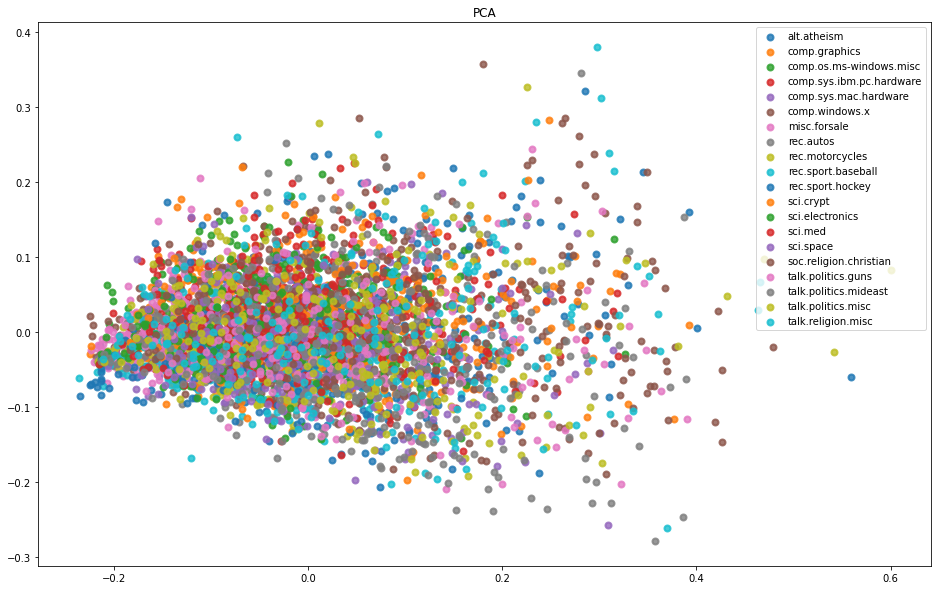

In [35]:
plt.figure(1,figsize=(16,10))
colors = ["navy", "turquoise", "darkorange", "cyan","blue", "yellow","orange","lima","green","indigo","purple","deeppink","crimson","dodgerblue","aqua","gold","cornflowerblue","slategray","black","red","goldenrod"]
lw = 2

for i, target_name in zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], alpha=0.8, lw=lw, label=target_name
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

plt.show()

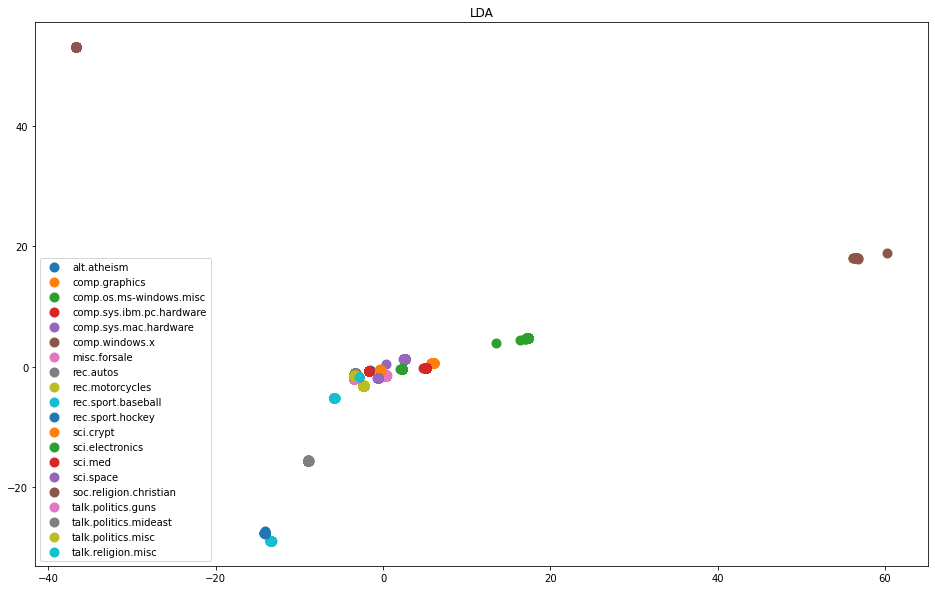

In [38]:
plt.figure(2,figsize=(16,10))
for i, target_name in zip( [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], linewidth=4, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA")

plt.show()